<a href="https://colab.research.google.com/github/Luisafrodriguezo1/Ejercicio_-Segmentacion-/blob/main/Ejercicio_SAM_UPRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentación (SAM y GeoAI)

## Caso de Estudio: Segmentación Geoespacial con Samgeo en el Municipio de Guasca

En este caso de estudio se utilizará la herramienta Samgeo, una interfaz geoespacial del modelo de inteligencia artificial Segment Anything Model (SAM), desarrollada por el investigador Qiusheng Wu. Esta herramienta permite aplicar segmentación automática sobre imágenes satelitales georeferenciadas, integrando visión por computador con análisis espacial.

Se instala el paquete llamado segment-geospatial, el cual está relacionado con Segment Anything Model (SAM) adaptado para aplicaciones geoespaciales.

 📌 [Documentación de Samgeo](https://samgeo.gishub.org/)



In [ ]:
pip install segment-geospatial --no-build-isolation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.2/564.2 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Se configura el entorno para realizar tareas de segmentación geoespacial, manipulación y visualización de datos ráster y vectoriales.

In [ ]:
import rasterio
from samgeo import SamGeo2
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import geopandas as gpd

Se realizará la segmentación de una manzana ubicada en el municipio de Guasca, utilizando el archivo ráster Orto_guasca_test.tif como fuente de imagen.

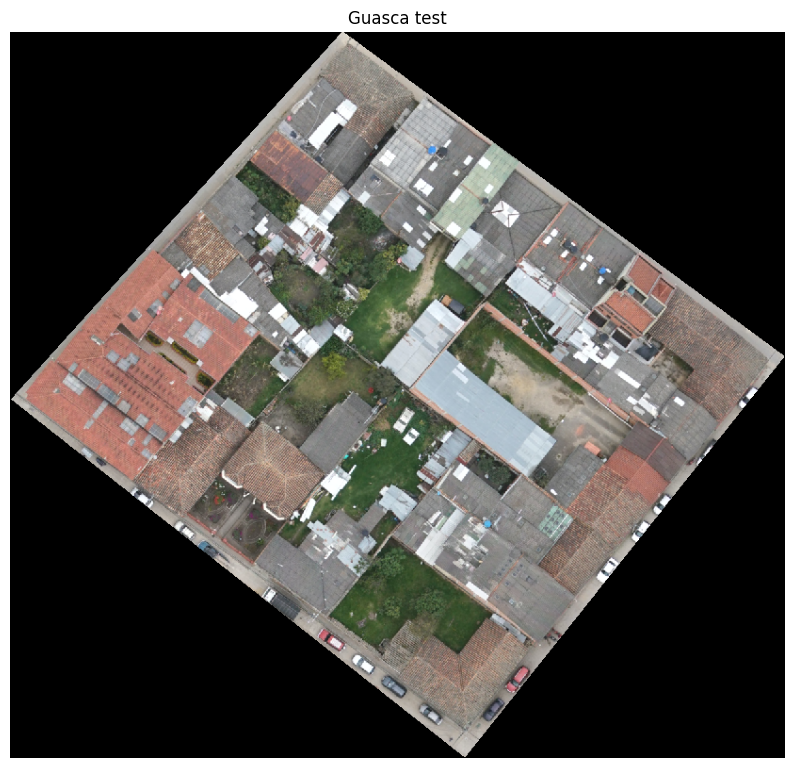

In [ ]:
image = '/content/drive/MyDrive/Orto_guasca_test.tif'
with rasterio.open(image) as src:
    # Leer las tres primeras bandas del raster
    band1 = src.read(1)
    band2 = src.read(2)
    band3 = src.read(3)

    # Obtener la transformación de afinidad para georreferenciar el raster
    transform = src.transform

    rgb_image = np.dstack((band1, band2, band3))

    # Crear una figura para la visualización
    plt.figure(figsize=(10, 10))

    # Mostrar la imagen RGB utilizando la función show de rasterio
    plt.imshow(rgb_image)
    plt.title("Guasca test")
    plt.axis('off')


    plt.show()

###  Carga del modelo SAMv2

Se carga el modelo **SAMv2** utilizando la clase `SamGeo2`, con los siguientes parámetros:

- `model_id="sam2-hiera-large"`: Usa el modelo grande **Hiera-SAM v2**.
- `automatic=True`: Activa la **segmentación automática** de toda la imagen.
- `points_per_side=128`: Define la **densidad de puntos** para segmentar; a mayor valor, mayor detalle.
- `pred_iou_thresh=0.8`: Umbral mínimo de **IoU (intersección sobre unión)** para conservar predicciones confiables.
- `stability_score_thresh=0.8`: Umbral de **estabilidad** que filtra predicciones inestables.

In [ ]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    automatic=True,
    points_per_side=128,  # prueba aumentar a 128
    pred_iou_thresh=0.8,
    stability_score_thresh=0.8,

)

Se ejecuta la segmentación de la imagen proporcionada, utilizando el modelo SAMv2 configurado previamente.

In [ ]:
sam2.generate(image)

 `sam2.save_masks` guarda las máscaras segmentadas generadas por el modelo en un archivo ráster georreferenciado.

In [ ]:
sam2.save_masks(output="masks_test.tif")

Se convierte un archivo ráster de máscaras segmentadas en un archivo vectorial (shapefile).

In [ ]:
sam2.raster_to_vector("/content/masks_test.tif", "masks_test.shp")

Creamos la función `graficar_mascara_sobre_raster()` que muestra un ráster RGB** (como una ortofoto) y superpone una capa vectorial (por ejemplo, máscaras segmentadas) para visualización conjunta.

In [ ]:
def graficar_mascara_sobre_raster(raster, vector, titulo):
    """
    Visualiza un ráster RGB con una capa vectorial superpuesta.

    Parámetros:
    - raster (str): Ruta al archivo .tif.
    - vector (str): Ruta al archivo .shp o .geojson.
    - titulo (str): Título del gráfico.
    """
    # Leer raster RGB
    with rasterio.open(raster) as src:
        rgb = np.dstack([src.read(i) for i in (1, 2, 3)])
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Normalizar si es necesario
    if rgb.max() > 255:
        rgb = rgb / 65535.0
    else:
        rgb = rgb / 255.0

    # Leer vector
    gdf = gpd.read_file(vector)

    # Visualizar
    plt.figure(figsize=(12, 12))
    plt.imshow(rgb, extent=extent)
    gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='lime', linewidth=1)
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

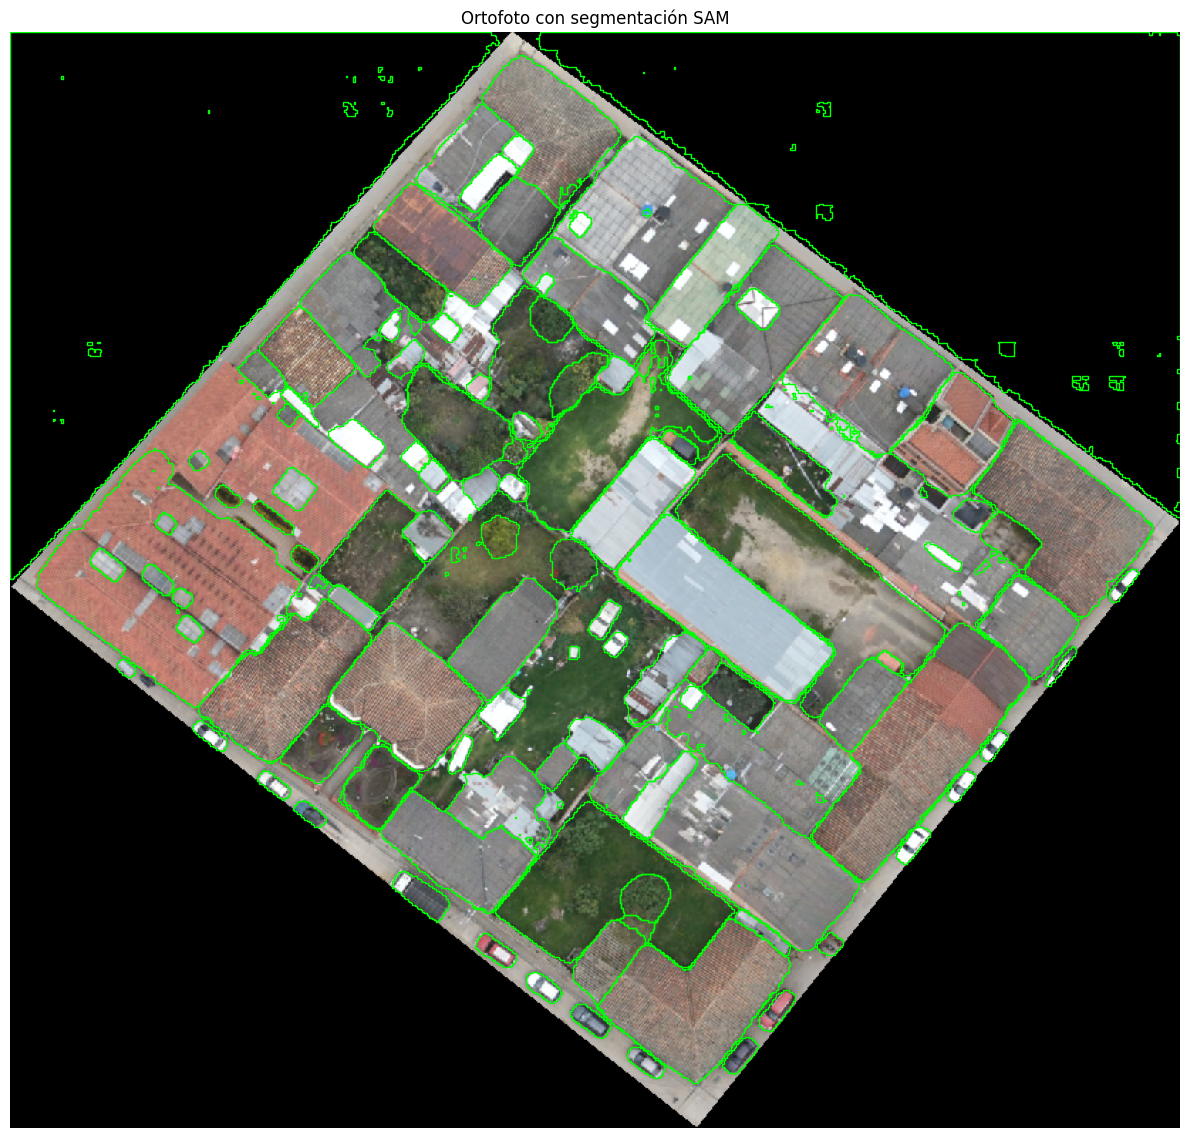

In [ ]:
graficar_mascara_sobre_raster(
    raster="/content/drive/MyDrive/Orto_guasca_test.tif",
    vector="/content/masks_test.shp",
    titulo="Ortofoto con segmentación SAM"
)


El modelo `sam2` genera un campo adicional en el archivo vectorial resultante que **indica el grupo al que pertenece cada polígono**

In [ ]:
gdf = gpd.read_file("/content/masks_test.shp")
gdf

value                                           geometry
0     41.0  POLYGON ((4902752.3 2096025.05, 4902752.6 2096...
1     90.0  POLYGON ((4902752.3 2096021.45, 4902752.45 209...
2     90.0  POLYGON ((4902752.15 2096021.15, 4902752.3 209...
3     83.0  POLYGON ((4902758.75 2096020.4, 4902758.9 2096...
4     90.0  POLYGON ((4902751.1 2096019.95, 4902751.25 209...
..     ...                                                ...
945  115.0  POLYGON ((4902773.6 2095927.25, 4902773.75 209...
946  115.0  POLYGON ((4902768.35 2095926.65, 4902768.5 209...
947   43.0  POLYGON ((4902776.3 2095929.8, 4902776.75 2095...
948   39.0  POLYGON ((4902764.3 2095928.75, 4902765.2 2095...
949  113.0  POLYGON ((4902774.35 2095942.25, 4902775.1 209...

[950 rows x 2 columns]

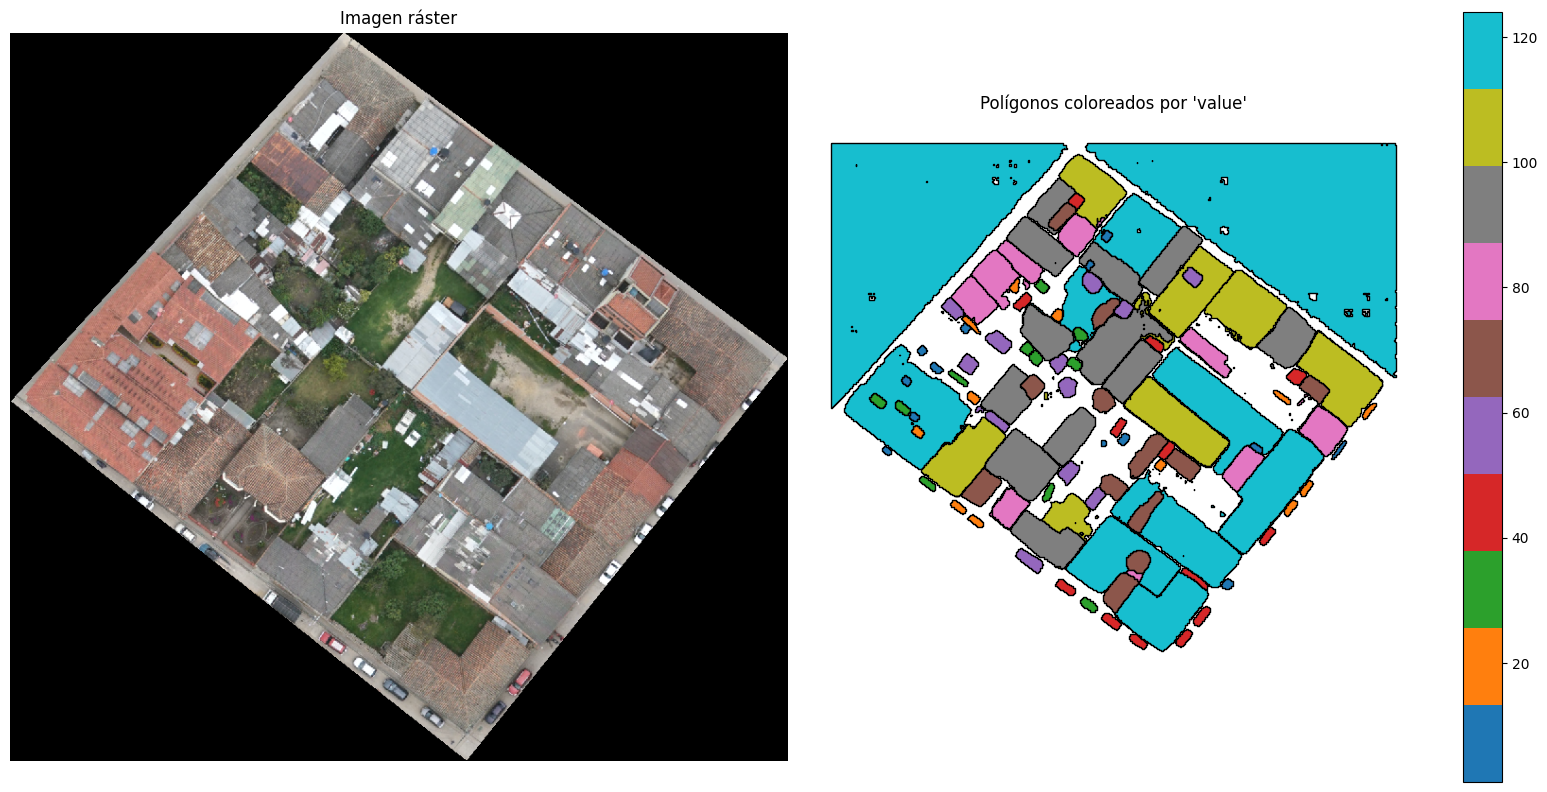

In [ ]:
# Rutas
raster_path = image

with rasterio.open(raster_path) as src:
    image = src.read([1, 2, 3]).transpose(1, 2, 0)  # Ráster RGB
    raster_crs = src.crs
    transform = src.transform

# Reproyectar vector si no coincide el CRS
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# Plot: lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Ráster a la izquierda
axs[0].imshow(image)
axs[0].set_title("Imagen ráster")
axs[0].axis("off")

# Vectores coloreados por 'value'
gdf.plot(column="value", cmap="tab10", legend=True, ax=axs[1], edgecolor='black')
axs[1].set_title("Polígonos coloreados por 'value'")
axs[1].axis("off")

plt.tight_layout()
plt.show()

## Caso de Estudio: Entrenar un modelo de detección de cubiertas en Guasca

En este caso de estudio se utilizará la herramienta **GeoAI** para la detección de cubiertas en el municipio de **Guasca**, empleando la red neuronal **Mask R-CNN**. Este enfoque combina el análisis geoespacial con técnicas avanzadas de visión por computador para identificar y segmentar cubiertas en imágenes satelitales.


### Geoai

[GeoAI](https://geoai.gishub.org) es un proyecto de código abierto que integra inteligencia artificial con análisis geoespacial en Python. Permite visualizar, procesar, segmentar y clasificar datos satelitales y vectoriales usando modelos como Segment Anything y técnicas de *deep learning*.

Es liderado por el **GeoAI Lab** de la **University of Tennessee, Knoxville**, bajo la dirección del Dr. **Qiusheng Wu**, experto en SIG y análisis geoespacial con Python.

In [ ]:
%pip install geoai-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.2/564.2 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/

In [ ]:
import geoai

```{admonition} Nota:Requisitos de datos
:class: tip

Para este caso de estudio se requieren los siguientes insumos geoespaciales:

- **Raster de entrenamiento**: imagen satelital de alta resolución correspondiente al municipio de Guasca, utilizada para entrenar el modelo.
- **Polígonos de cubiertas**: archivo vectorial (por ejemplo, en formato GeoJSON o Shapefile) que contiene las delimitaciones de las cubiertas en el área de entrenamiento. Estas servirán como etiquetas para el modelo.
- **Raster de prueba (test)**: imagen satelital del área donde se desea aplicar el modelo y realizar la predicción.
```
   

In [ ]:
train_raster_path = "/content/drive/MyDrive/curso/guasca/Orto_guasca_train.tif"
train_vector_path = "/content/drive/MyDrive/curso/guasca/train_guasca.shp"
test_raster_path = "/content/drive/MyDrive/curso/guasca/Orto_guasca_test.tif"

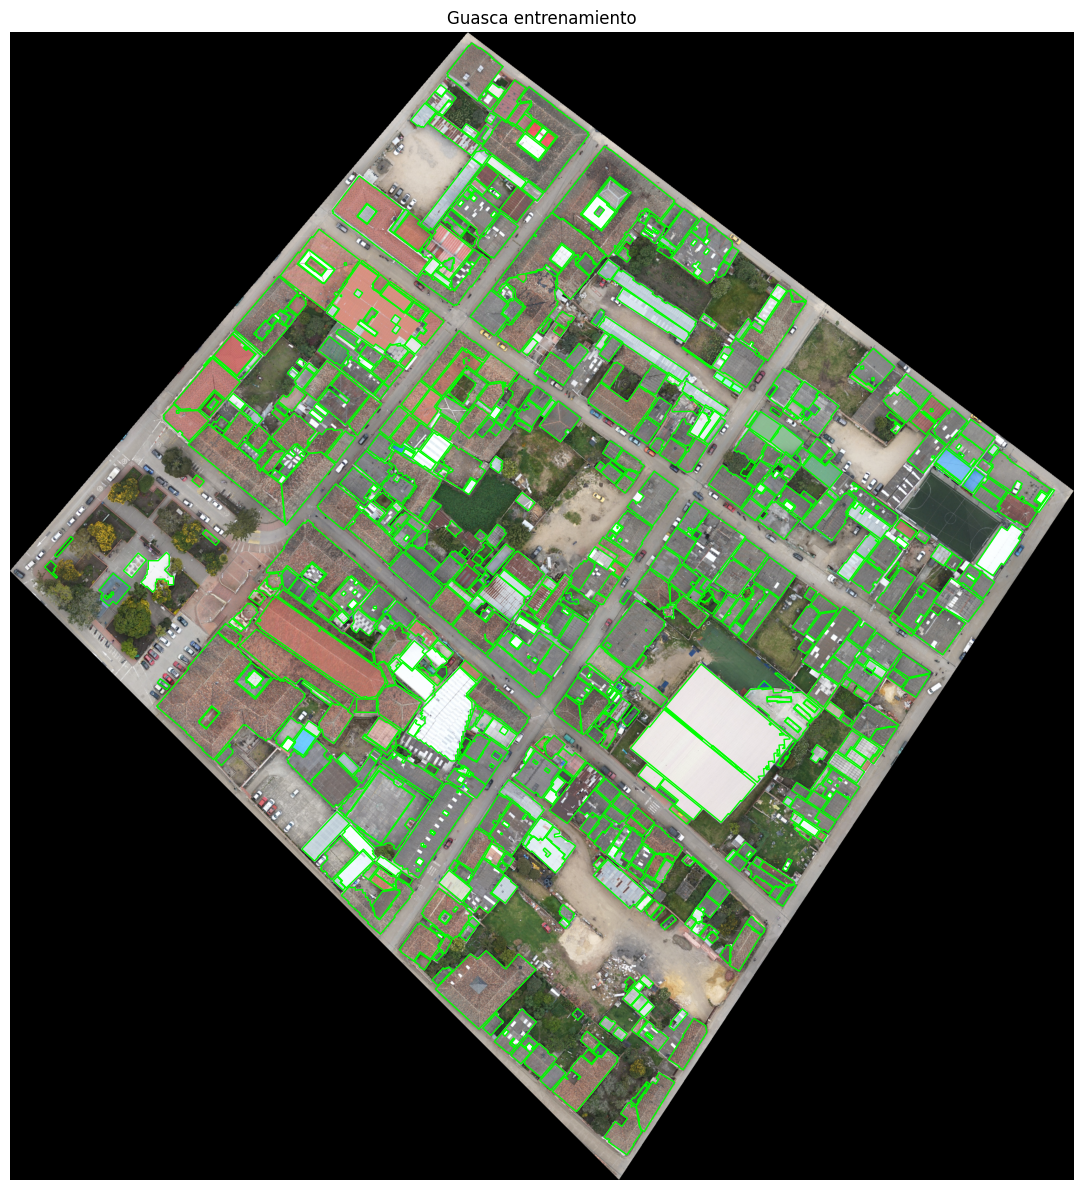

In [ ]:
graficar_mascara_sobre_raster(
    raster=train_raster_path,
    vector=train_vector_path,
    titulo="Guasca entrenamiento"
)


La función `geoai.export_geotiff_tiles()` para preparar los datos de entrenamiento para un modelo de aprendizaje profundo

Esta función corta el raster de entrada (`train_raster_path`) en mosaicos pequeños (o *tiles*) junto con sus respectivas etiquetas derivadas del vector (`train_vector_path`), de la siguiente manera:

- **`in_raster`**: ruta al raster de entrada.
- **`out_folder`**: carpeta de salida donde se guardarán los tiles generados.
- **`in_class_data`**: ruta al archivo vectorial con las clases (polígonos de cubiertas).
- **`tile_size=512`**: cada tile tendrá un tamaño de 512×512 píxeles.
- **`stride=256`**: el paso entre tiles será de 256 píxeles (los tiles se superponen un 50%).
- **`buffer_radius=0`**: no se incluye área adicional (buffer) alrededor de cada tile.

In [ ]:
out_folder = "output"
tiles = geoai.export_geotiff_tiles(
    in_raster=train_raster_path,
    out_folder=out_folder,
    in_class_data=train_vector_path,
    tile_size=512,
    stride=256,
    buffer_radius=0,
)


Raster info for /content/drive/MyDrive/curso/guasca/Orto_guasca_train.tif:
  CRS: ESRI:103599
  Dimensions: 2446 x 2639
  Resolution: (0.1500000000001523, 0.1500000000001523)
  Bands: 3
  Bounds: BoundingBox(left=4902666.8, bottom=2095587.35, right=4903033.7, top=2095983.2000000004)
Loaded 648 features from /content/drive/MyDrive/curso/guasca/train_guasca.shp
Vector CRS: PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


Generated: 90, With features: 77: 100%|██████████| 90/90 [00:16<00:00,  5.32it/s]


------- Export Summary -------
Total tiles exported: 90
Tiles with features: 77 (85.6%)
Average feature pixels per tile: 85942.0
Output saved to: output

------- Georeference Verification -------



Al ejecutar la función `geoai.export_geotiff_tiles()`, se obtiene la siguiente información sobre los datos vectoriales y los tiles exportados:

- **CRS del vector**: `MAGNA-SIRGAS Origen Nacional`  
  El vector se encuentra en el mismo sistema de coordenadas que el raster

- **Características cargadas**: 648  
  Se detectaron 648 entidades (polígonos de cubiertas) en el archivo vectorial.

- **Advertencia**: No se encontró un campo llamado `'class'` en los atributos del vector.  
  Como resultado, se asignó automáticamente una única clase con ID `1` a todos los polígonos.

**Exportación de mosaicos (tiles)**

- **Tiles generados**: 90  
- **Tiles que contienen cubiertas (features)**: 77 (85.6%)
- **Promedio de píxeles etiquetados por tile**: 85,942
- **Carpeta de salida**: `output`

La función genera tres carpetas principales dentro del directorio de salida (`output/`), cada una con archivos correspondientes a los tiles generados:

- **`annotations/`**: contiene los archivos `.xml` con la información de anotación para cada tile, como cajs delimitadoras
  Ejemplo:  
  `xml_path = /content/output/annotations/tile_000003.xml`

- **`images/`**: contiene los fragmentos del raster original en formato `.tif`. Estos son los tiles de entrada para el modelo.  
  Ejemplo:  
  `image_path = /content/output/images/tile_000003.tif`

- **`labels/`**: contiene las máscaras de segmentación correspondientes a cada tile, también en formato `.tif`. Estas son las etiquetas del modelo.  
  Ejemplo:  
  `mask_path = /content/output/labels/tile_000003.tif`



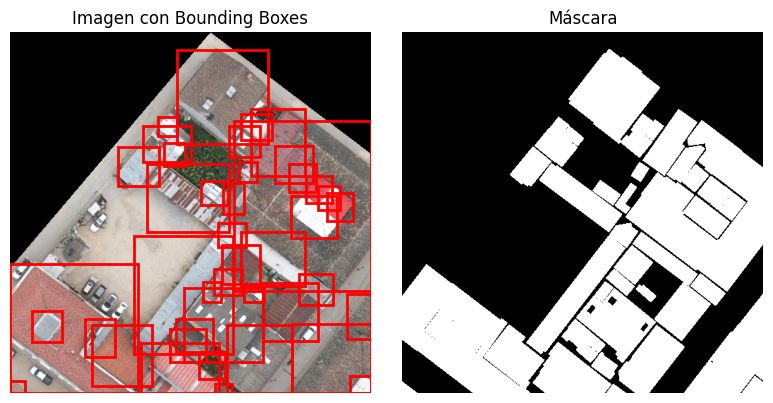

In [ ]:
import xml.etree.ElementTree as ET
from matplotlib.patches import Rectangle

# Rutas a tus archivos
xml_path = "/content/output/annotations/tile_000003.xml"
image_path = "/content/output/images/tile_000003.tif"
mask_path = "/content/output/labels/tile_000003.tif"

# -------------------------------
# 1. Leer y parsear el XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Extraer bounding boxes
boxes = []
for obj in root.findall("object"):
    bndbox = obj.find("bndbox")
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    boxes.append((xmin, ymin, xmax, ymax))

# -------------------------------
# 2. Leer imagen RGB y máscara
with rasterio.open(image_path) as src_img:
    image = src_img.read([1, 2, 3]).transpose(1, 2, 0)  # HWC

with rasterio.open(mask_path) as src_mask:
    mask = src_mask.read(1)  # Capa única

# -------------------------------
# 3. Visualizar solo imagen con cajas y máscara
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Imagen con bounding boxes
axs[0].imshow(image)
axs[0].set_title("Imagen con Bounding Boxes")
for xmin, ymin, xmax, ymax in boxes:
    rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     edgecolor='red', facecolor='none', linewidth=2)
    axs[0].add_patch(rect)

# Solo la máscara
axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Máscara")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


La función `geoai.train_MaskRCNN_model()` entrena un modelo de segmentación de cubiertas utilizando la arquitectura **Mask R-CNN**. A continuación se describen los parámetros principales:

- **`output_dir`**: carpeta donde se almacenará el modelo entrenado y otros archivos generados.  
  Ejemplo: `output/models/`

- **`num_channels`**: número de bandas o canales en las imágenes de entrada. Para imágenes RGB se usa `3`.

- **`pretrained`**: si es `True`, utiliza un modelo base preentrenado (por ejemplo, en COCO) para transferir conocimiento y acelerar el entrenamiento.

- **`batch_size`**: número de imágenes que se procesan en cada paso de entrenamiento.

- **`num_epochs`**: cantidad de veces que el modelo verá todo el conjunto de entrenamiento. Un número alto generalmente mejora la precisión (con suficiente validación para evitar sobreajuste).

- **`learning_rate`**: tasa de aprendizaje del modelo, que controla cuánto se ajustan los pesos en cada paso de entrenamiento.

- **`val_split`**: proporción del conjunto de datos que se reserva para validación. Por ejemplo, `0.2` significa que el 20% se usará para validar el rendimiento del modelo.

In [ ]:
geoai.train_MaskRCNN_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/models",
    num_channels=3,
    pretrained=True,
    batch_size=4,
    num_epochs=100,
    learning_rate=0.005,
    val_split=0.2,
)

Using device: cuda
Found 90 image files and 90 label files
Training on 72 images, validating on 18 images


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 180MB/s]


Epoch: 0, Batch: 0/18, Loss: 6.6666, Time: 5.87s
Epoch: 0, Batch: 10/18, Loss: 1.1635, Time: 9.34s
Epoch 1/100: Train Loss: 1.9618, Val Loss: inf, Val IoU: 0.4457
Saving best model with IoU: 0.4457
Epoch: 1, Batch: 0/18, Loss: 1.5684, Time: 2.45s
Epoch: 1, Batch: 10/18, Loss: 1.4045, Time: 9.69s
Epoch 2/100: Train Loss: 1.1938, Val Loss: inf, Val IoU: 0.5664
Saving best model with IoU: 0.5664
Epoch: 2, Batch: 0/18, Loss: 0.9301, Time: 2.32s
Epoch: 2, Batch: 10/18, Loss: 0.9631, Time: 10.09s
Epoch 3/100: Train Loss: 0.9697, Val Loss: inf, Val IoU: 0.6250
Saving best model with IoU: 0.6250
Epoch: 3, Batch: 0/18, Loss: 0.7975, Time: 2.07s
Epoch: 3, Batch: 10/18, Loss: 0.9047, Time: 10.57s
Epoch 4/100: Train Loss: 0.8395, Val Loss: inf, Val IoU: 0.6345
Saving best model with IoU: 0.6345
Epoch: 4, Batch: 0/18, Loss: 0.7466, Time: 2.35s
Epoch: 4, Batch: 10/18, Loss: 0.6785, Time: 10.61s
Epoch 5/100: Train Loss: 0.7156, Val Loss: inf, Val IoU: 0.6735
Saving best model with IoU: 0.6735
Epoch: 

In [ ]:
masks_path = "test_prediction.tif"
model_path = f"{out_folder}/models/best_model.pth"



La función `geoai.object_detection()` aplica un modelo previamente entrenado **Mask R-CNN** sobre un **raster de prueba** con el objetivo de **detectar y segmentar objetos** geoespaciales.

Este proceso consiste en dividir la imagen en ventanas, realizar inferencia sobre cada una usando el modelo y reconstruir una máscara de predicción completa que representa las áreas detectadas.

In [ ]:
geoai.object_detection(
    test_raster_path,
    masks_path,
    model_path,
    window_size=512,
    overlap=256,
    confidence_threshold=0.5,
    batch_size=4,
    num_channels=3,
)

Processing 9 windows with size 512x512 and overlap 256...


16it [00:02,  7.89it/s]

Inference completed in 2.03 seconds
Saved prediction to test_prediction.tif


Ahora, se convierten las máscaras raster resultantes de una predicción en polígonos vectoriales simplificados y alineados ortogonalmente

In [ ]:
output_path = "test_predic.geojson"
gdf = geoai.orthogonalize(masks_path, output_path, epsilon=2)

Processing 94 features...


Converting features: 100%|██████████| 94/94 [00:00<00:00, 128.58shape/s]


Saving to test_predic.geojson...
Done!


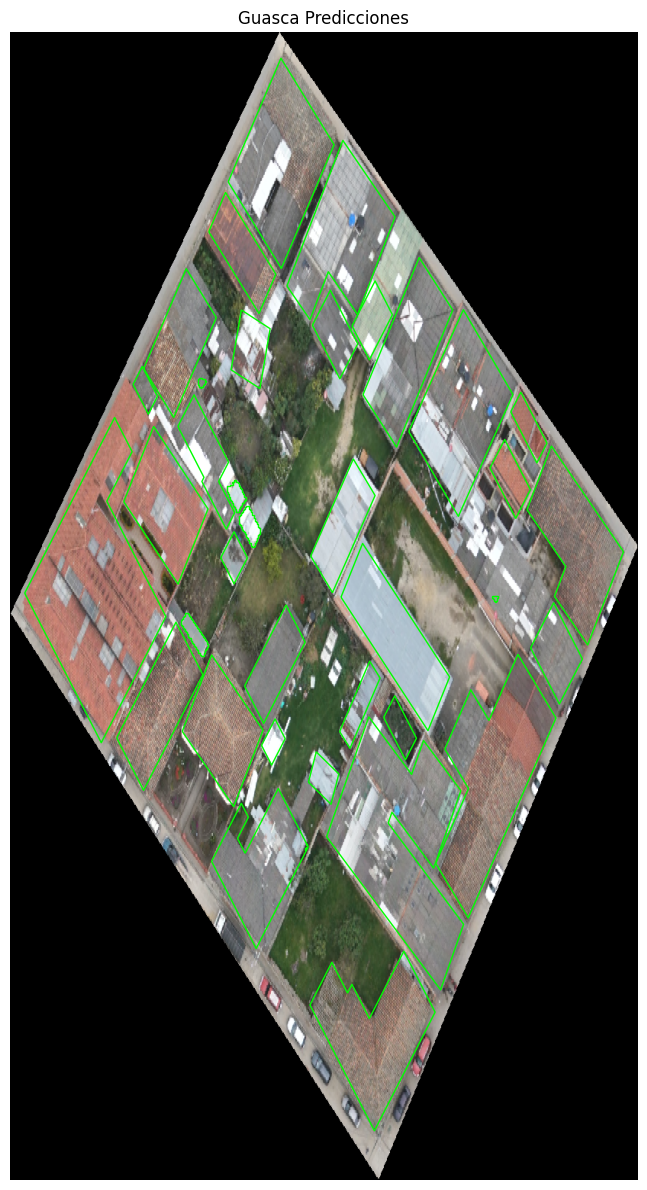

In [ ]:
graficar_mascara_sobre_raster(
    raster=test_raster_path,
    vector=output_path,
    titulo="Guasca Predicciones"
)

## Análisis de Resultados o Conclusiones

El uso de GeoAI en este caso de estudio demuestra el potencial de combinar inteligencia artificial con análisis geoespacial para automatizar tareas que tradicionalmente requerían mucho tiempo, como la detección de cubiertas a partir de imágenes satelitales. A través de un flujo estructurado desde la preparación de datos, entrenamiento del modelo con Mask R-CNN, hasta la predicción y postprocesamiento ortogonalizado es posible generar resultados precisos, reutilizables y fácilmente integrables en sistemas de información geográfica (SIG).

Comparado con  SAM (Segment Anything Model), GeoAI requiere mayor preparación inicial, especialmente en la generación de etiquetas de entrenamiento, pero ofrece un control mucho más fino y resultados específicos adaptados a las necesidades del proyecto. Mientras SAM destaca por su capacidad de segmentar rápidamente cualquier objeto sin entrenamiento previo, su naturaleza generalista lo hace menos adecuado cuando se buscan salidas limpias, ortogonales y orientadas a una clase particular como las cubiertas.

## Referencias

*Wu, Q., & Osco, L. (2023). *samgeo: A Python package for segmenting geospatial data with the Segment Anything Model (SAM)*. *Journal of Open Source Software, 8*(89), 5663. https://doi.org/10.21105/joss.05663

*Osco, L. P., Wu, Q., de Lemos, E. L., Gonçalves, W. N., Ramos, A. P. M., Li, J., & Junior, J. M. (2023). *The Segment Anything Model (SAM) for remote sensing applications: From zero to one shot*. *International Journal of Applied Earth Observation and Geoinformation, 124*, 103540. https://doi.org/10.1016/j.jag.2023.103540

*Wu, Q. (2025). *GeoAI: Artificial Intelligence for Geospatial Data* [Software]. Recuperado de https://geoai.gishub.org/
